# Project: **Finding Lane Lines on the Road** 



## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


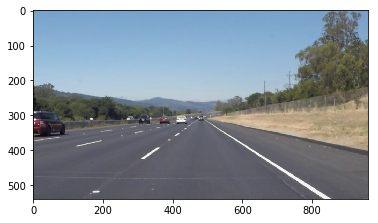

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

## Helper Functions

In [3]:
import math
prev_slope_right = 0.6
prev_slope_left = -0.6
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    # declare global variable for a first order filter
    global prev_slope_right
    global prev_slope_left
    alpha = 0.45
    
    #establish x-min and x-max coordinates for left and right lines  
    xmin_left, xmin_right = 0, int(img.shape[1]/2)+20
    xmax_left, xmax_right = int(img.shape[1]/2)-20, img.shape[1] 

    #collect y1, x1 and slope for left and right lines
    #look for (-) slope for left lines and (+) slope for right lines  
    slopes_left, slopes_right = [], []
    y1s_left, x1s_left = [], []
    y1s_right, x1s_right = [], []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
             # negative slope: line coordinates belongs to left line
            if (prev_slope_left*0.75) > slope > (prev_slope_left*1.25):  
                slopes_left += [slope]
                y1s_left += [y1]
                x1s_left += [x1]
            # positive slope: line coordinates belongs to right line
            elif (prev_slope_right*1.15) > slope > (prev_slope_right*0.85): 
                slopes_right += [slope]
                y1s_right += [y1]
                x1s_right += [x1]
    
    #average slopes for left and right lines
    avg_slope_left = np.mean(slopes_left)
    avg_slope_right = np.mean(slopes_right)
    
    #slope first order filters
    avg_slope_left = alpha * avg_slope_left + (1-alpha) * prev_slope_left
    avg_slope_left = alpha * avg_slope_left + (1-alpha) * prev_slope_left
   
    #update previous slope global variables
    prev_slope_left, prev_slope_right = avg_slope_left, avg_slope_right
    
    #compute ymin and ymax for the left line
    intercept_left = np.mean(y1s_left) - avg_slope_left * np.mean(x1s_left)
    ymin_left = intercept_left
    ymax_left = (avg_slope_left * xmax_left + (intercept_left))
    
    #compute ymin and ymax for right line 
    intercept_right = np.mean(y1s_right) - avg_slope_right * np.mean(x1s_right)
    ymin_right = (avg_slope_right * xmin_right + (intercept_right))
    ymax_right = (avg_slope_right * xmax_right + (intercept_right))
      
    #draw left and right lines
    if (slopes_left):       #safe gaurds for empty mean
        cv2.line(img, (xmin_left, int(ymin_left)), (xmax_left, int(ymax_left)), color, thickness)
    if (slopes_right):     #safe gaurds for empty mean
        cv2.line(img, (xmin_right, int(ymin_right)), (xmax_right, int(ymax_right)), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """ 
    initial_img * α + img * β + γ
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



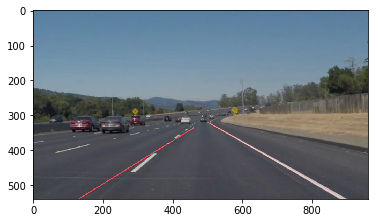

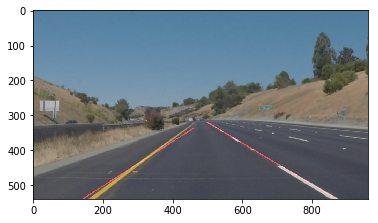

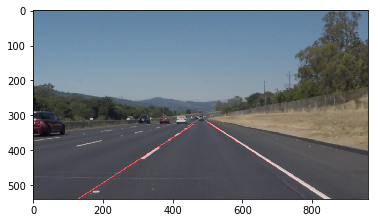

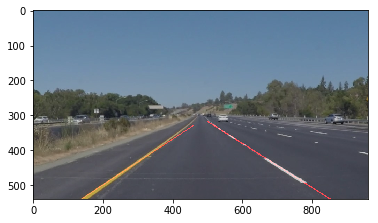

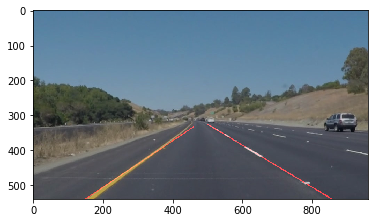

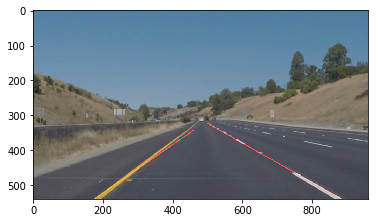

In [5]:
def piplineImage(img_path):
    init_img = mpimg.imread(img_path)
    img = grayscale(init_img)
    img = gaussian_blur(img,5)
    img = canny(img,50,150)
    imshape = img.shape
    vertices = np.array(
          [[
            (0.10*imshape[1], imshape[0]),
            (0.47*imshape[1], 0.57*imshape[0]),
            (0.51*imshape[1], 0.57*imshape[0]),
            (0.97*imshape[1], imshape[0])
          ]],
          dtype=np.int32
      )
    img = region_of_interest(img,vertices)
    img = hough_lines(img ,2,np.pi/180,15,40,25)
    img = weighted_img(img,init_img)
    plt.imshow(img)
    plt.show()
lst_paths=["test_images/"+i for i in os.listdir("test_images/")]
for i in lst_paths:
    piplineImage(i)

## Testing on Videos

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    img = gaussian_blur(img,5)
    img = canny(img,50,150)
    imshape = img.shape
    vertices = np.array(
          [[
            (0.10*imshape[1], imshape[0]),
            (0.47*imshape[1], 0.57*imshape[0]),
            (0.51*imshape[1], 0.57*imshape[0]),
            (0.97*imshape[1], imshape[0])
          ]],
          dtype=np.int32
      )
    img = region_of_interest(img,vertices)
    img = hough_lines(img ,2,np.pi/180,15,40,25)
    img = weighted_img(img,image)
    return img


Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.67 s, sys: 236 ms, total: 2.9 s
Wall time: 14.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:42<00:00, 15.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.38 s, sys: 516 ms, total: 8.89 s
Wall time: 44.6 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))